# Imports and System Setup

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from pytexit import py2tex
from IPython.display import Markdown
from gekko import GEKKO
import pandas as pd
from matplotlib import rcParams
import os
import sys
from copy import copy
from pytexit import py2tex


import sympy as sp
sp.init_printing()


%matplotlib widget
#%matplotlib inline

# Look for custom python codes in the Radigan Engineering Vault...
sys.path.insert(1, 'C:\\\\RadiganVault\\\\Python')

import RadiganEngineeringDefaults as RE
from RadiganEngineering_Materials_Library import *
from RadiganEngineeringTorsionSpring import *
from RadiganEngineeringBellevilleSpring import *

# Use higher quality figures in PDF exports
#rcParams['figure.dpi']= 300
#rcParams['figure.figsize'] = [8, 6]
set_matplotlib_formats('png', 'pdf')

print(ALUMINUM_6061_T6.Specific_Heat)

896 joule / kelvin / kilogram


# GEKKO Non-Linear Model

In [2]:
# https://apmonitor.com/pdc/index.php/Main/TCLabSim
# https://apmonitor.com/pdc/index.php/Main/TCLabConvection

# Update model with natural convection estimation.

TCLab = GEKKO(remote=False)    # create GEKKO model for dx/dt

t_sim = 1500 * ureg.sec # Number of seconds to simulate
points_per_second = 1 # Only works if this is the same as the 'sampling frequency' in the cell below...

TCLab.time = np.linspace(0, t_sim.magnitude, (t_sim.magnitude * points_per_second) + 1) * ureg.sec # time points

# dt is in the units of ________.

# --> Inputs (7):
T_Ambient = Q_(23.0, ureg.degC)
HS_Mass  = 0.004 * ureg.kg 
HS_Cp    = 500.0 * (ureg.joule /  (ureg.kg    * ureg.kelvin)) # Heatsink Specific Heat
HS_Conv  = 5.0   * (ureg.watt) / ((ureg.m**2) * ureg.kelvin)  # Convection coefficient
# NOTE: This lesson changes the convection coefficient from 10 to 5 W/m^2-K, in order to make a better match when including the RADIATION TERM.
HS_Area  = 0.0012 * ureg.m**2                                 # Heatsink Surface Area

sigma    = 5.67e-8 # W/m2-K4
epsilon  = 0.9

# Starting temperature for the heatsink.
# Might be equal to 'T_Ambient' or something else.
HS_T_Start = T_Ambient
#HS_T_Start = Q_(23.0, ureg.degC)

#HeaterControl = 'manual'
HeaterControl = 'p_only'
CollectData = False

if (HeaterControl == 'manual'):
    #############################################################
    ################ HEATER STEP INPUT ##########################
    # Curve defining the heater setting over the course of time.
    HeaterValues = np.zeros(len(TCLab.time))
    HeaterValues[15:300] = 20
    HeaterValues[300:600] = 75
    HeaterValues[600:900] = 0
    HeaterValues[900:1200] = 50
    #HeaterValues[15:800] = 50
    #HeaterValues[0:9] = 50
    Heater_Q  = TCLab.Param(HeaterValues)  # "Percentage of maximum value" of the heater
    #############################################################
    #############################################################

if (HeaterControl == 'p_only'):
    # Proportional control only...
    T_SetPoint = np.zeros(len(TCLab.time)) + T_Ambient.to('degC').magnitude
    T_SetPoint[10:400] = 65.0
    #T_SetPoint[400:]  = 35.0
    #T_SetPoint[900:]  = 30.0
    
    
    TCLab_PID = GEKKO(remote=False)    # create GEKKO model for dx/dt

    t_sim = 1500 * ureg.sec # Number of seconds to simulate
    points_per_second = 1 # Only works if this is the same as the 'sampling frequency' in the cell below...

    TCLab_PID.time = np.linspace(0, t_sim.magnitude, (t_sim.magnitude * points_per_second) + 1) * ureg.sec # time points

    # Controller model
    # Gain Calculated for Aggressive Control (Set-Point Tracking) is --> 6.028 percent / delta_degree_Celsius
    # Gain Calculated for Disturbance Rejection is                is --> 10.615 percent / delta_degree_Celsius
    # 
    Kc = 26.028                  # controller gain
    #tauI = 1.0                  # controller reset time
    #tauD = 1.0                  # derivative constant
    
    OP_0 = TCLab_PID.Const(value=0.0)   # OP bias
    OP = TCLab_PID.Var(value=0.0)#, lb=0.0, ub=100.0)       # controller output --> THE UPPER BOUND and LOWER BOUND don't seem to work like I expect them too...
    #OP = TCLab.MV(value=0.0, ub=100)#; OP.STATUS = 1       # controller output
    PV = TCLab_PID.Var(value=T_Ambient.to('degC').magnitude)       # process variable defaults to Ambient Temperature
    SP = TCLab_PID.Param(value=T_SetPoint)    # set point
    Intgl = TCLab_PID.Var(value=0.0)    # integral of the error
    err = TCLab_PID.Intermediate(SP-PV) # set point error
    TCLab_PID.Equation(Intgl.dt()==err) # integral of the error
    
    # PID Control
    #TCLab.Equation(OP == OP_0 + Kc*err + (Kc/tauI)*Intgl - PV.dt()) 
    
    # P-Only Control
    TCLab_PID.Equation(OP == OP_0 + Kc*err)
    
    # Process model
    # FOPDT Parameters Estimated from: TCL = pd.read_csv('2020_11_23_TCLab_Measured_Data.csv')
    # Using This Equation:
    # m.Equation(tau * yp.dt() + (yp-y_SteadyState) == K * (HeaterValue_cspline - u_SteadyState))
    #     Kp     = 0.703 degC / %
    #     Tau_p  = 189.487 seconds
    #     thetap = 15.510 seconds
    Kp     = 0.703     # degC / %                    # process gain
    tauP   = 189.487   # seconds                # process time constant
    thetap = 15.510    #  seconds
    #TCLab_PID.Equation(time_plus_delay==time-theta)
#     GKL_alpha = 0.0
#     GKL_Beta  = 0.005
#     GKL_gamma = -0.006181061174034302
    TCLab_PID.Equation(tauP*PV.dt() + PV ==  Kp*OP)
    # # This is the 'Linearized' model equation.
    # TCLab_Linear.Equation(GKL_HS_Temp_C.dt()  == GKL_alpha + GKL_gamma * (GKL_HS_Temp_C - GKL_Temperature_Linearization_Point) + 
    #                                                          GKL_Beta  * (GKL_Heater_Q  - GKL_Heater_Linearization_Point) )

    TCLab_PID.options.IMODE=4
    #TCLab.options.NODES = 3
    #TCLab.options.TIME_SHIFT=0
    TCLab_PID.solve(disp=False)
    
    # Use the Heater Values calculated by the control equations as the basis 
    # for the dynamic simulatiosn below
    HeaterValues = np.zeros(len(TCLab_PID.time))
    HeaterValues = np.clip(OP.value, 0.0, 100)
    
    Heater_Q  = TCLab.Param(HeaterValues)  # "Percentage of maximum value" of the heater
    #print(Heater_Q)
    #print(HeaterValues)
    
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(TCLab_PID.time,OP.value,'b:',label='OP')
    plt.ylabel('Output')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(TCLab_PID.time,SP.value,'k-',label='SP')
    plt.plot(TCLab_PID.time,PV.value,'r--',label='PV')
    plt.xlabel('Time (sec)')
    plt.ylabel('Process')
    plt.legend()
    plt.show()



Heater_Coefficient = 0.01 # ~= 0.01 Watts / %
GK_Heater_Coefficient       = TCLab.Param(Heater_Coefficient) # This seems a little low, I would have expected more than 1 Watt at full power [100%] from the USB source.

# --> States (1): (Variables, with initial conditions)
#print('Heatsink Starting Temperature is {0}'.format(HS_T_Start.to('degC').magnitude))
GK_HS_Temp_C   = TCLab.Var(HS_T_Start.to('degC').magnitude) # GEKKO variable for the temperature of the heatsink

# --> Equations (1): 
GK_HS_Temp_K  = TCLab.Intermediate(GK_HS_Temp_C + 273.15) # Convert to Kelvin for the Radiation term
GK_Convection = TCLab.Intermediate(  (HS_Conv.to('watt/(m^2*K)').magnitude * HS_Area.to('m^2').magnitude) * (T_Ambient.to('kelvin').magnitude - GK_HS_Temp_K)  )
GK_Radiation  = TCLab.Intermediate(  sigma * epsilon * HS_Area.to('m^2').magnitude * (T_Ambient.to('kelvin').magnitude**4 - GK_HS_Temp_K**4)  )
GK_Loss       = TCLab.Intermediate(GK_Convection + GK_Radiation)
GK_Gain       = TCLab.Intermediate(GK_Heater_Coefficient * Heater_Q)


# GEKKO model Equation
TCLab.Equation(GK_HS_Temp_C.dt()  == ( GK_Convection + GK_Radiation + GK_Gain ) / 
                                     (HS_Mass.to('kg').magnitude * HS_Cp.to('joule/(kg*K)').magnitude) )



############### GEKKO SOLVER OPTIONS ######################
# solve ODEs and plot
# https://gekko.readthedocs.io/en/latest/imode.html
TCLab.options.IMODE = 4 # dynamic simulation

# Type: Integer, Input/Output
# Default Value: 0
# Description: Cold start model: 0=warm start, 1=cold start, 2=decompose problem
#TCLab.options.COLDSTART = 2

#TCLab.options.SOLVER = 1
#TCLab.options.MAX_ITER = 1000

TCLab.options.NODES = 3
TCLab.options.TIME_SHIFT=0

# Solve the dynamic system
TCLab.solve(disp=False)
############### GEKKO SOLVER OPTIONS ######################

C:\ProgramData\Anaconda3\lib\site-packages\gekko\gk_write_files.py:144: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  csv_data = np.hstack(('time',np.array(self.time).flatten().astype(object)))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\ProgramData\Anaconda3\lib\site-packages\gekko\gk_write_files.py:144: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  csv_data = np.hstack(('time',np.array(self.time).flatten().astype(object)))


# SymPy Analytical Solution

'Full Model Equation:'

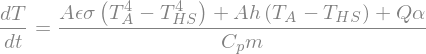

'"gamma" is the Model partial derivitive with respect to "SP_Temp_HS":'

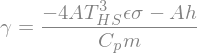

Given:
   T_Ambient    = 296.1 kelvin | 23.0 degree_Celsius


'If:'

   T_HS    = 296.1 kelvin | 23.0 degree_Celsius
   Area    = 0.0012 meter ** 2
   epsilon = 0.9
   sigma   = 5.67e-08
   h       = 5.0 watt / kelvin / meter ** 2
   Cp      = 500.0 joule / kelvin / kilogram
   mass    = 0.004 kilogram


'Then:'

'In Python:'

-0.006181061267852783





'"Beta" is the Model partial derivitive with respect to "SP_Heater_Q":'

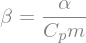

'If:'

   mass     = 0.004 kilogram
   C_p      = 500.0 joule / kelvin / kilogram
   alpha    = 0.01


'Then:'

'In Python:'

0.004999995231628418


In [3]:
##########################################################################
############################### SymPy ####################################
# SymPy equations for the partial derivitives
SP_h,SP_Area,SP_T_Ambient,SP_Temp_HS = sp.symbols(['h','A','T_A','T_HS']) # Convection symbols
spConvection                  = (SP_h * SP_Area) * (SP_T_Ambient - SP_Temp_HS)
#display('Convection Term:')
#display(spConvection)

SP_sigma, SP_epsilon            = sp.symbols(['sigma','epsilon'])
SP_Radiation                   = SP_sigma * SP_epsilon * SP_Area * (SP_T_Ambient**4 - SP_Temp_HS**4)
#display('Radiation Term:')
#display(SP_Radiation)

SP_Heater_Coefficient, SP_Heater_Q            = sp.symbols(['alpha','Q'])
SP_Gain                        = SP_Heater_Coefficient * SP_Heater_Q
#display('Heat Gain Term:')
#display(SP_Gain)


# Sympy Equation
SP_mass, SP_C_p, SP_dTdt  = sp.symbols(['m','C_p',r'\frac{dT}{dt}'])
SP_TCModel =  (spConvection + SP_Radiation + SP_Gain) / (SP_mass * SP_C_p)
#display('Model Equation Right-Hand-Side:')
#display(SP_TCModel)

# A SymPy 'Equation' includes what is on both the RIGHT and LEFT hand side of the '='
SP_TCLab_Equation = sp.Eq(SP_dTdt, SP_TCModel )
display('Full Model Equation:')
display(SP_TCLab_Equation)

# Sympy symbols for the linearized models.
SP_gamma,SP_beta = sp.symbols(['gamma','beta'])

display('"gamma" is the Model partial derivitive with respect to "SP_Temp_HS":')
gamma = sp.Eq(SP_gamma,sp.diff(SP_TCModel , SP_Temp_HS))
display(gamma)

# NOTE: The model is linearized in "Degrees Celsius", but 'gamma' is calculated in 'Kelvin'!
#Linearization_Temp = HS_T_Start
Linearization_Temp = T_Ambient
#Linearization_Temp = Q_(90.0, ureg.degC)

print('Given:')
print('   T_Ambient    = {0:.1f} | {1:.1f}'.format(T_Ambient.to('kelvin'), T_Ambient.to('degC')) )

display('If:')
print('   T_HS    = {0:.1f} | {1:.1f}'.format(Linearization_Temp.to('kelvin'), Linearization_Temp.to('degC')) )
print('   Area    = {0}'.format(HS_Area.to('m^2')))
print('   epsilon = {0}'.format(epsilon))
print('   sigma   = {0}'.format(sigma))
print('   h       = {0}'.format(HS_Conv.to('watt/(m^2*K)')))
print('   Cp      = {0}'.format(HS_Cp.to('joule/(kg*K)')))
print('   mass    = {0}'.format(HS_Mass.to('kg')))
display('Then:')
gamma_solved = (sp.sympify(gamma.subs(SP_Temp_HS , Linearization_Temp.to('kelvin').magnitude)
                                .subs(SP_Area, HS_Area.to('m^2').magnitude)
                                .subs(SP_epsilon, epsilon)
                                .subs(SP_sigma, sigma)
                                .subs(SP_h, HS_Conv.to('watt/(m^2*K)').magnitude)
                                .subs(SP_C_p, HS_Cp.to('joule/(kg*K)').magnitude)
                                .subs(SP_mass,   HS_Mass.to('kg').magnitude  )
                                .evalf(4) ))
display(gamma_solved)

print('\n')
display('In Python:')
print(float(gamma_solved.rhs))

print('\n\n')
display('"Beta" is the Model partial derivitive with respect to "SP_Heater_Q":')
beta = sp.Eq(SP_beta, sp.diff(SP_TCModel , SP_Heater_Q) )
display(beta)
display('If:')
print('   mass     = {0}'.format(HS_Mass.to('kg')))
print('   C_p      = {0}'.format(HS_Cp.to('joule/(kg*K)')))
print('   alpha    = {0}'.format(Heater_Coefficient))
display('Then:')
beta_solved = (sp.sympify(beta.subs(SP_mass,   HS_Mass.to('kg').magnitude  )
                              .subs(SP_Heater_Coefficient,   Heater_Coefficient  )
                              .subs(SP_C_p,   HS_Cp.to('joule/(kg*K)').magnitude  )
                              .evalf(4) ))

display(beta_solved)
display('In Python:')
print(float(beta_solved.rhs))
############################### SymPy ####################################
##########################################################################

# GEKKO Linearized Model

In [4]:
#########################################################################
#################### LINEARIZED GEKKO MODEL #############################

#ANS_gamma = -U*A/(m*Cp) - 4*eps*sigma*A*TaK**3/(m*Cp)
#ANS_beta = alpha/(m*Cp)

TaK = Linearization_Temp.to('kelvin').magnitude
ANSWER_beta = Heater_Coefficient /(HS_Mass.to('kg').magnitude * HS_Cp.to('joule/(kg*K)').magnitude)

ANSWER_gamma = -HS_Conv.to('watt/(m^2*K)').magnitude * HS_Area.to('m^2').magnitude / (HS_Mass.to('kg').magnitude * HS_Cp.to('joule/(kg*K)').magnitude)  - 4*epsilon*sigma*HS_Area.to('m^2').magnitude*TaK**3  /  ( HS_Mass.to('kg').magnitude *  HS_Cp.to('joule/(kg*K)').magnitude )

#print('ANSWER_gamma = {}'.format(ANSWER_gamma))
#print('ANSWER_beta  = {}'.format(ANSWER_beta))

TCLab_Linear = GEKKO(remote=False)    # create GEKKO model for dx/dt
TCLab_Linear.time = np.linspace(0, t_sim.magnitude, (t_sim.magnitude * points_per_second) + 1) * ureg.sec # time points

GKL_HS_Temp_C   = TCLab_Linear.Var(HS_T_Start.to('degC').magnitude) # GEKKO variable for the temperature of the heatsink
GKL_Heater_Q    = TCLab_Linear.Param(HeaterValues)  # "Percentage of maximum value" of the heater

GKL_Heater_Linearization_Point      = 0.0
# NOTE: The model is linearized in "Degrees Celsius", but 'gamma' is calculated in 'Kelvin'!
GKL_Temperature_Linearization_Point = Linearization_Temp.to('degC').magnitude

# # These gamma and Beta calculations come from the analytical (SymPy) solution above.
# GKL_gamma       = TCLab_Linear.Param(float(gamma_solved.rhs))
# GKL_Beta        = TCLab_Linear.Param(float(beta_solved.rhs))

# These gamma and Beta calculations come from the hand-calculated derivitives, and
# the equations defined above.
GKL_gamma       = TCLab_Linear.Param(ANSWER_gamma)
GKL_Beta        = TCLab_Linear.Param(ANSWER_beta)


# These are constant values that are preliminary computations for the 'alpha' term in the model linearization below.
# The model can be 'linearized' at any point to minimize the errors at that point
GKL_HS_Temp_K  = GKL_Temperature_Linearization_Point + 273.15 # Convert to Kelvin for the Radiation term
GKL_Convection = (HS_Conv.to('watt/(m^2*K)').magnitude * HS_Area.to('m^2').magnitude) * (T_Ambient.to('kelvin').magnitude - GKL_HS_Temp_K)
GKL_Radiation  = sigma * epsilon * HS_Area.to('m^2').magnitude * (T_Ambient.to('kelvin').magnitude**4 - GKL_HS_Temp_K**4)
GKL_Gain       = Heater_Coefficient * GKL_Heater_Linearization_Point

# This 'alpha' term is f(x0,u0) --> Which is the non-linear function evaluated at the x0, u0 linearization points
GKL_alpha = ( GKL_Convection + GKL_Radiation + GKL_Gain ) / (HS_Mass.to('kg').magnitude * HS_Cp.to('joule/(kg*K)').magnitude)


print('GKL_alpha = {0}'.format(GKL_alpha))
print('GKL_Beta  = {0}'.format(GKL_Beta.value))
print('GKL_gamma = {0}'.format(GKL_gamma.value))


# This is the 'Linearized' model equation.
TCLab_Linear.Equation(GKL_HS_Temp_C.dt()  == GKL_alpha + GKL_gamma * (GKL_HS_Temp_C - GKL_Temperature_Linearization_Point) + 
                                                         GKL_Beta  * (GKL_Heater_Q  - GKL_Heater_Linearization_Point) )

############### GEKKO SOLVER OPTIONS ######################
# solve ODEs and plot
# https://gekko.readthedocs.io/en/latest/imode.html
TCLab_Linear.options.IMODE = 4 # dynamic simulation

# Type: Integer, Input/Output
# Default Value: 0
# Description: Cold start model: 0=warm start, 1=cold start, 2=decompose problem
#TCLab_Linear.options.COLDSTART = 2

#TCLab_Linear.options.SOLVER = 1
#TCLab_Linear.options.MAX_ITER = 1000

TCLab_Linear.options.NODES = 3
TCLab_Linear.options.TIME_SHIFT=0

# Solve the dynamic system
TCLab_Linear.solve(disp=False)
############### GEKKO SOLVER OPTIONS ######################

#################### LINEARIZED GEKKO MODEL #############################
#########################################################################

GKL_alpha = 0.0
GKL_Beta  = 0.005
GKL_gamma = -0.006181061174034302


# Plot Simulation Results

In [5]:
########################################################################
####################### PLOT SIMULATION RESULTS ########################
fig = plt.figure(figsize=(12,4))
plt_ax = plt.subplot(1,3,1)
#plt_ax = plt.axes(label='TCLab')
#plt_ax.set_ylim(20,65)
#plt_ax.set_ylim(T_Ambient.to('degC').magnitude - 5.0, max(GK_HS_Temp_C.value) + 5.0)


print('Max Predicted Temperature = {0:.2f}'.format(max(GK_HS_Temp_C.value)))

# Plot the heatsink temperature as a function of time NON-LINEAR MODEL! (And Heater input curve...)
plt_ax.plot(TCLab.time,       GK_HS_Temp_C, color = 'blue', linestyle = '-', marker='',linewidth=1,label=r'$\alpha$ = {0}'.format(GK_Heater_Coefficient.value[0]))

# Plot the heatsink temperature from the LINEAR MODEL as a function of time. (And Heater input curve...)
plt_ax.plot(TCLab_Linear.time,GKL_HS_Temp_C, color = 'blue', linestyle = ':', marker='',linewidth=1,label=r'NL $\alpha$ = {0}'.format(GK_Heater_Coefficient.value[0]))


#######################################################################
# Create the 'dummy' plot with NaN's that will be replaced
# with measured data below.
T1 = np.empty(len(TCLab.time))
T1[:] = np.nan
T1_time = np.empty(len(TCLab.time))
T1_time[:] = np.nan
MeasuredDataPlot, = plt_ax.plot(T1_time,T1,'r.', label='Measured')
#######################################################################

plt.grid(True)
plt.title('TC Lab Thermal Simulation')
plt.xlabel('Time (sec)')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()

# Make a second plot that shows the heat Gain & Loss terms
plt_ax2 = plt.subplot(1,3,2)
plt_ax2.plot(TCLab.time,GK_Convection, color = 'blue',   linestyle = '-', marker='',linewidth=1,label='Convection')
plt_ax2.plot(TCLab.time,GK_Radiation,  color = 'orange', linestyle = '-', marker='',linewidth=1,label='Radiation')
plt_ax2.plot(TCLab.time,GK_Loss,       color = 'green',  linestyle = '-', marker='',linewidth=1,label='Total Loss')
plt_ax2.plot(TCLab.time,GK_Gain,       color = 'red',    linestyle = '-', marker='',linewidth=1,label='Heater Gain')
plt.title('TC Lab Heat Gain & Loss Terms')
plt.xlabel('Time (sec)')
plt.ylabel('Energy (Watts)')
plt.legend()
plt.grid(True)

# instantiate a second axes that shares the same x-axis 
# and plot the Heater Input
Q_ax = plt.subplot(1,3,3)
#Q_ax = plt_ax2.twinx()  
Q_ax.plot(TCLab.time,Heater_Q, color = 'gray', linestyle = ':', marker='',linewidth=2,label='Heater')
Q_ax.set_ylim(-5,105)
Q_ax.grid(True)
plt.ylabel('Heater Percentage of Full Scale')
plt.xlabel('Time (sec)')
plt.title('Heater Output')
#plt.legend(loc = 'lower right')

plt.subplots_adjust(wspace = 0.4 )

if (HeaterControl == 'p_only'):
    plt_ax.plot(TCLab_PID.time,       PV, color = 'blue', linestyle = ':', marker='',linewidth=1,label='PV')
    plt_ax.plot(TCLab_PID.time,       SP, color = 'gray', linestyle = '--', marker='',linewidth=1,label='SP')

    Q_ax.plot(TCLab_PID.time,       OP, color = 'green', linestyle = '-', marker='',linewidth=1,label='PID_OP')

Q_ax.legend(loc = 'lower right');
plt_ax.legend();

####################### PLOT SIMULATION RESULTS ########################
########################################################################

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Max Predicted Temperature = 80.84


# Collect Data from Arduino-Based TCLab For Comparison with Simulated Results

In [6]:
# Actual measured data
import tclab
import time

#CollectData = True
if (HeaterControl == 'manual') and (CollectData == True):
    lab = tclab.TCLab()
    
    # Use the array defined above to set the heater.
    lab.Q1(HeaterValues[0])
    Start_Time = time.time()

    T1[:] = np.nan       # Reset the measured temperatures to NaN's
    T1_time[:] = np.nan
    DTime = np.empty_like(HeaterValues)
    ElapsedTime = np.empty_like(HeaterValues)
    
    for i in range(len(TCLab.time)):
        #time.sleep(1)
        time.sleep(0.70) # ~0.30 sec 'overhead' time
        lab.Q1(HeaterValues[i])
        T1[i] = lab.T1
        T1_time[i] = i
        DTime[i] = time.time()
        ElapsedTime[i] = DTime[i] - Start_Time
        
        print('N = {3}, Time = {4:.1f}, T1 = {0}, T2 = {1}, Heater Set to {2}'.format(lab.T1, lab.T2, HeaterValues[i], i, ElapsedTime[i]))
        MeasuredDataPlot.set_ydata(np.array(T1))
        #MeasuredDataPlot.set_xdata(np.array(T1_time))
        MeasuredDataPlot.set_xdata(ElapsedTime)
        plt_ax.set_title("{0} of {1} Points Measured".format(i+1,t_sim))
        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.show()
    
    PD_MeasuredData = pd.DataFrame(data = {'DTime':  DTime,
                                        'ElapsedTime': ElapsedTime,
                                        'T1': T1,
                                        'T1_time': T1_time,
                                        'HeaterValues': HeaterValues
                                       })
    PD_MeasuredData.to_csv('TCLab_Measured_Data.csv')
    lab.close()
    plt.show()

## DEBUG: Open TCLab and report current Temperatures

In [7]:
if (0): # Grab the current temperature from the TCLab if desired. (I.e. = 1)
    import tclab
    lab = tclab.TCLab()
    print('T1 = {0}, T2 = {1}'.format(lab.T1, lab.T2))
    print('T1 = {0}, T2 = {1}'.format(lab.T1, lab.T2))
    print('T1 = {0}, T2 = {1}'.format(lab.T1, lab.T2))
    lab.close()

## DEBUG: Close TCLab Connection

In [8]:
#lab.close()